In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet_v2 import Resnet4Channel

In [3]:
gpu_device = 1

defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [4]:
path = Path('/home/haider/data/human_protein_atlas/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


Visualizing : https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline

In [6]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [7]:
train_labels = df.copy(0)

for key in label_names.keys():
    train_labels[label_names[key]] = 0
    
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()


,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


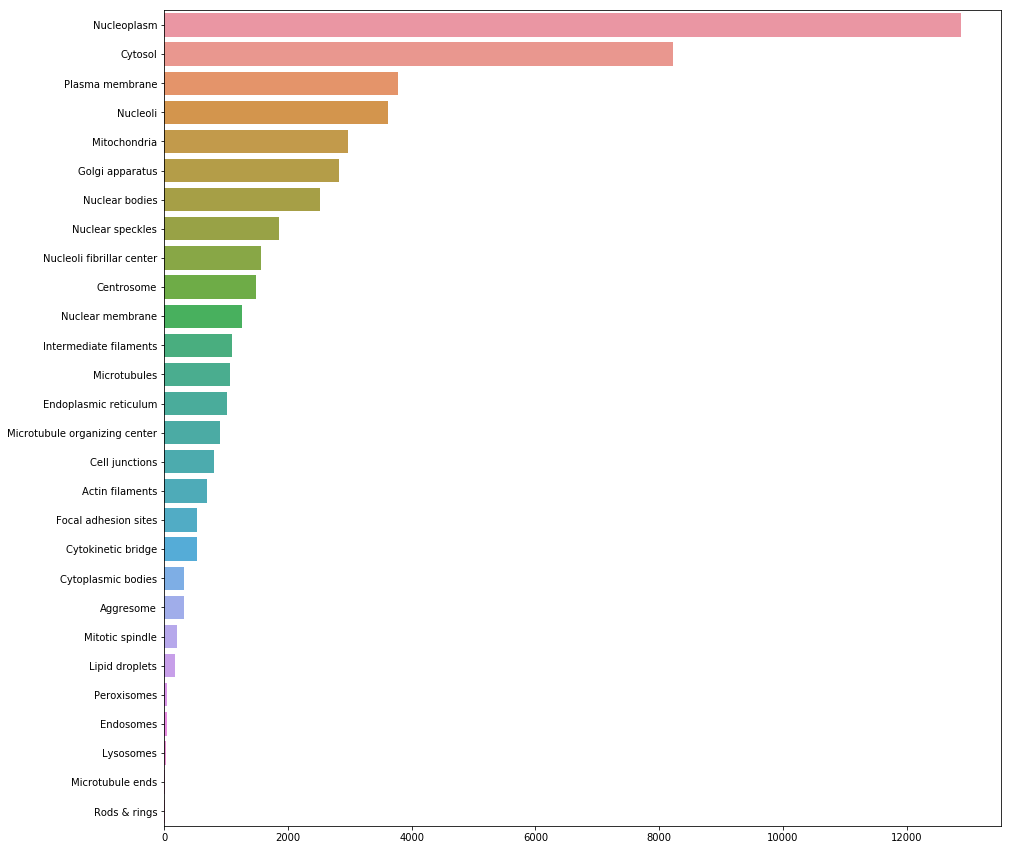

In [8]:
import seaborn as sns

target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

Oversampling using Brian code : https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/75691#446302

In [9]:
train_df_orig=df.copy()    
lows = [15,15,15,8,9,10,8,9,10,8,9,10,17,20,24,26,15,27,15,20,24,17,8,15,27,27,27]
for i in lows:
    target = str(i)
    indicies = train_df_orig.loc[train_df_orig['Target'] == target].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.startswith(target+" ")].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.endswith(" "+target)].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)
    indicies = train_df_orig.loc[train_df_orig['Target'].str.contains(" "+target+" ")].index
    df = pd.concat([df,train_df_orig.loc[indicies]], ignore_index=True)

In [10]:
train_labels = df.copy(0)

for key in label_names.keys():
    train_labels[label_names[key]] = 0
    
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()


,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


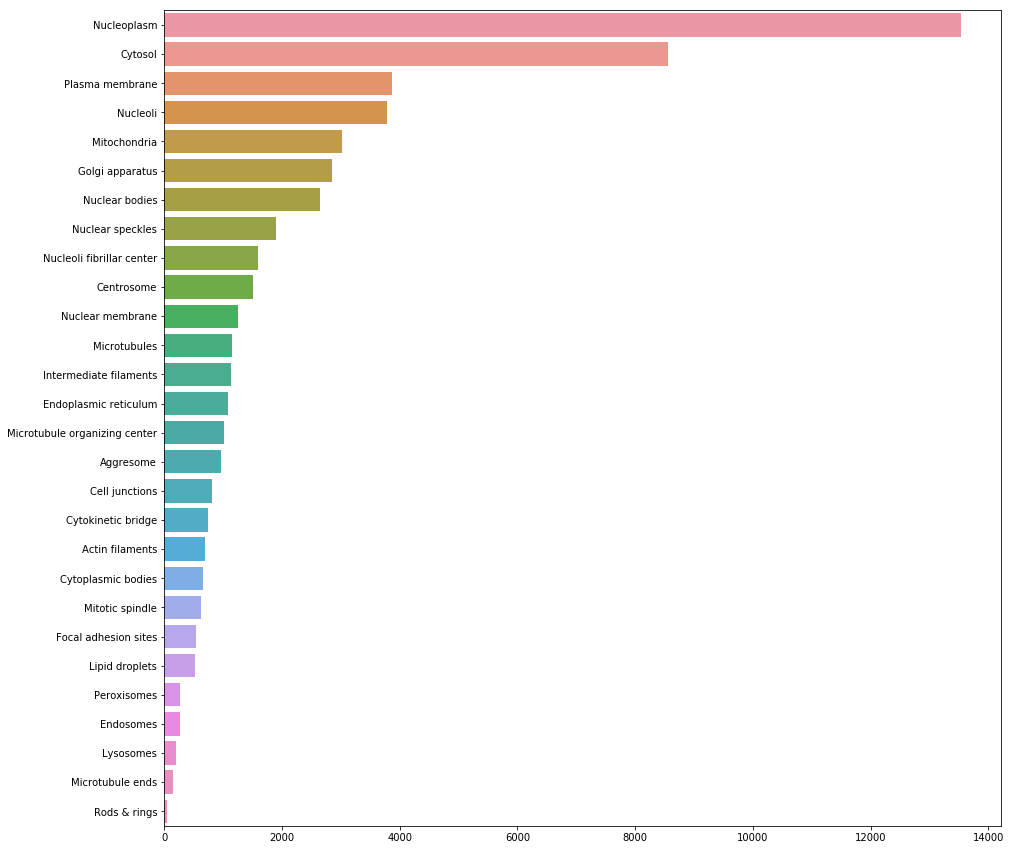

In [11]:
import seaborn as sns

target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

In [12]:
# im_count = df.Id.value_counts()
# im_count.name = 'sighting_count'
# df = df.join(im_count, on='Id')
# val_fns = set(df.sample(frac=1).groupby('Id').first().Image)

In [13]:
# fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [14]:
# path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [15]:
path

PosixPath('/home/haider/data/human_protein_atlas')

In [16]:
np.random.seed(1002)
src = (ImageItemList.from_df(df, path=path/'train', suffix='.png', cols=['Id'])
       .random_split_by_pct(0.2)
       .label_from_df(cols=['Target'], sep=' ',  classes=[str(i) for i in range(28)]))

In [17]:
# data = (
#     ImageItemList
#         .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
#         .split_by_valid_func(lambda path: path2fn(path) in val_fns)
#         .label_from_func(lambda path: fn2label[path2fn(path)])
#         .add_test(ImageItemList.from_folder('data/test'))
#         .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
#         .normalize(imagenet_stats)
# )

In [18]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [19]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [20]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [21]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [22]:
test_fnames[:5]

[PosixPath('/home/haider/data/human_protein_atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [23]:
src.add_test(test_fnames, label='0');

In [24]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [25]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [26]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [27]:
src.train.x

ImageItemList (26728 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train

In [28]:
src.valid.x

ImageItemList (6681 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train

total train+valid dataset = 33409 . while before oversampling it was 31072

In [29]:
NUM_WORKERS = 8
BS = 64//4

In [30]:
data = (src.transform((trn_tfms, _), size=512)
        .databunch(bs=BS, num_workers=NUM_WORKERS).normalize(protein_stats))

#        .normalize(imagenet_stats)

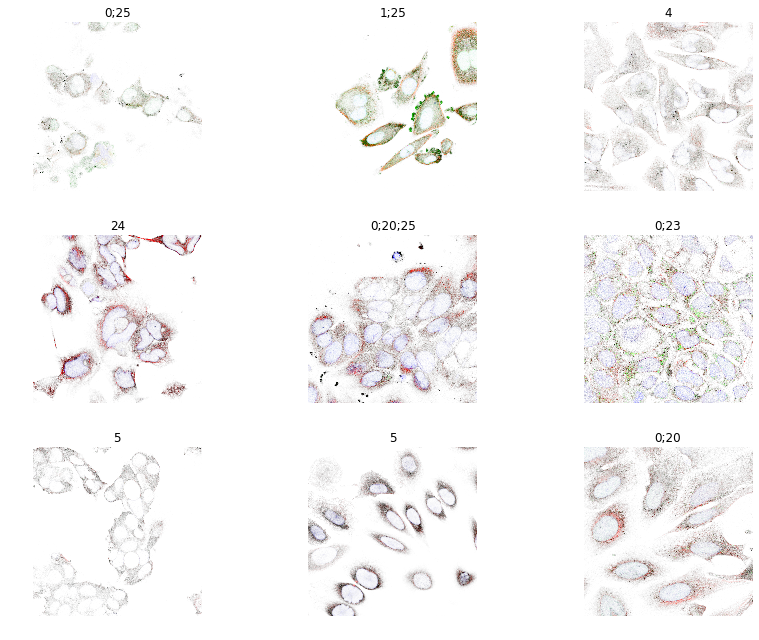

In [31]:
data.show_batch(rows=3, figsize=(12,9))

In [32]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [33]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): 
    # import pdb; pdb.set_trace()  ; m[0] returns the body ; m[0][6] returns the 7th block of the body ; m[1] returns the head; 
    # so it seems this function specifies the points that divides the 3 groups for the differential learning rates
    return (m[0][6],m[1])

In [34]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [35]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


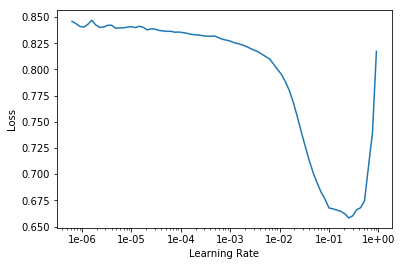

In [51]:
learn.recorder.plot()

In [36]:
lr = 3e-2/4

In [53]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.138555,0.122888,0.561273
2,0.115031,0.104682,0.653604
3,0.110731,0.095255,0.682567
4,0.099316,0.089647,0.704035
5,0.097479,0.087580,0.704045


In [54]:
learn.save('stage-1-rn50-datablocks_rn50_sz512-os')

In [37]:
learn.load('stage-1-rn50-datablocks_rn50_sz512-os')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (26728 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 25;2]...
Path: /home/haider/data/human_protein_atlas/train
x: ImageItemList (26728 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train;

Valid: LabelList
y: MultiCategoryList (6681 items)
[MultiCategory 25;0, MultiCategory 25;13;3;0, MultiCategory 25;23;2, MultiCategory 26, MultiCategory 14;0]...
Path: /home/haider/data/human_protein_atlas/train
x: ImageItemList (6681 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train;

Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: /home/haider/data/human_pro

In [38]:
learn.unfreeze()

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(10, slice(3e-5/4, lr/5))

epoch,train_loss,valid_loss,fbeta
1,0.098347,0.086499,0.708970
2,0.100877,0.092190,0.687667
3,0.102107,0.095582,0.689193
4,0.091624,0.087793,0.713722
5,0.087929,0.081197,0.730719
6,0.087302,0.077726,0.728779
7,0.082065,0.078111,0.750873
8,0.077775,0.070810,0.763200
9,0.071375,0.069932,0.766372
10,0.070597,0.069178,0.768479


In [40]:
learn.save('stage-2-rn50_sz512-os')

In [41]:
preds,y = learn.get_preds(DatasetType.Valid)
# y = to_np(y)
# preds = np.stack(preds, axis=-1)
# pred = preds.mean(axis=-1)  # This need when in fastai0.7 used TTA
pred = preds

## Iafoss thresholds and other tweaking methods below

In [118]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
# Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. 
# The code below does it automatically.

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
#     preds = to_np(preds)
    preds = sigmoid_np(d*(preds - th))
#     targs = to_np(targs)
#     targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0, wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [119]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [120]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th[:, None], average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

TypeError: sub(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

In [117]:
%debug


> <ipython-input-116-3f10e2ec51e8>(3)<module>()
      1 th = fit_val(pred,y)
      2 print('Thresholds: ',th)
----> 3 print('F1 macro: ',f1_score(y, pred>th[:, None], average='macro'))
      4 print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
      5 print('F1 micro: ',f1_score(y, pred>th, average='micro'))



ipdb>  u


*** Oldest frame


ipdb>  d


*** Newest frame


ipdb>  exit


Using CV to prevent overfitting the thresholds:

In [ ]:
# This function is trying to minimize (F1-1)^2 + wd^2*th^2. So, you are trying to get F1 close to 1. 
# while if something goes wrong, like there are just a few data points, thresholds do not go far away from 0.0. 
# Also, I'm using a soft version of F1 to have stable gradient in least square minimization.

from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Plot the distribution of lables to see how the model performs. Be aware about log scale.

In [ ]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

**Submission**

In [ ]:
preds_t,y_t = learn.get_preds(DatasetType.Test)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

In [ ]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

Save predictions for thresholds calculated based on the validation set and constant value 0.0:

In [ ]:
name = 'initialize_weight'

save_pred(pred_t,th,path/'subs'/f'{name}_v_th.csv')
save_pred(pred_t,0.0,path/'subs'/f'{name}_0_th.csv')

Similar to validation, additional adjustment may be done based on the public LB probing results (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/68678) to predict approximately the same fraction of images of a particular class as expected from the public LB (I replaced 0 by 0.01 since there may be a rounding error leading to 0). Automatic fitting the thresholds based on the public LB statistics:

Haider Update: Turned out it is very similar to the fractions of the train set, so don't think it is useful

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [ ]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,path/'subs'/f'{name}_f_th.csv')

Try using the threshold from validation set for classes not present in the public LB:

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,path/'subs'/f'{name}_c_th.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,path/'subs'/f'{name}_t_th.csv')

Brian's single threshold method

In [135]:
y

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
# !conda install -c anaconda scikit-learn -y

Solving environment: done

## Package Plan ##

  environment location: /home/haider/anaconda3/envs/fastai-v1

  added / updated specs: 
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    scikit-learn-0.20.1        |   py37h4989274_0         5.7 MB  anaconda
    ca-certificates-2018.03.07 |                0         124 KB  anaconda
    certifi-2018.10.15         |           py37_0         138 KB  anaconda
    ------------------------------------------------------------
                                           Total:        10.9 MB

The following NEW packages will be INSTALLED:

    scikit-learn:    0.20.1-py37h4989274_0 anaconda

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0                   --> 2018.03.07-0      anaconda
    openssl:         1.1.1a-h7b6447c_0      

In [42]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

# preds_y = model.predict(valid_x) # in his code mine is : preds_y -> preds; valid_y -> y

thresholds = np.linspace(0, 1, 1500)
score = 0.0
best_threshold=0.0
best_val = 0.0
for threshold in thresholds:
    score = f1_score(y > 0.5, preds > threshold, average='macro')
    if score > best_val:
        best_threshold = threshold
        best_val = score
    print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))



Threshold 0.0000, F1: 0.1018
Threshold 0.0007, F1: 0.1769
Threshold 0.0013, F1: 0.2137
Threshold 0.0020, F1: 0.2429
Threshold 0.0027, F1: 0.2665
Threshold 0.0033, F1: 0.2870
Threshold 0.0040, F1: 0.3047
Threshold 0.0047, F1: 0.3203
Threshold 0.0053, F1: 0.3349
Threshold 0.0060, F1: 0.3477
Threshold 0.0067, F1: 0.3591
Threshold 0.0073, F1: 0.3684
Threshold 0.0080, F1: 0.3795
Threshold 0.0087, F1: 0.3892
Threshold 0.0093, F1: 0.3982
Threshold 0.0100, F1: 0.4066
Threshold 0.0107, F1: 0.4156
Threshold 0.0113, F1: 0.4245
Threshold 0.0120, F1: 0.4323
Threshold 0.0127, F1: 0.4397
Threshold 0.0133, F1: 0.4470
Threshold 0.0140, F1: 0.4535
Threshold 0.0147, F1: 0.4596
Threshold 0.0153, F1: 0.4647
Threshold 0.0160, F1: 0.4702
Threshold 0.0167, F1: 0.4756
Threshold 0.0173, F1: 0.4812
Threshold 0.0180, F1: 0.4860
Threshold 0.0187, F1: 0.4909
Threshold 0.0193, F1: 0.4952
Threshold 0.0200, F1: 0.5001
Threshold 0.0207, F1: 0.5050
Threshold 0.0213, F1: 0.5095
Threshold 0.0220, F1: 0.5132
Threshold 0.02

/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold 0.9186, F1: 0.5331
Threshold 0.9193, F1: 0.5325
Threshold 0.9199, F1: 0.5319
Threshold 0.9206, F1: 0.5307
Threshold 0.9213, F1: 0.5296
Threshold 0.9219, F1: 0.5283
Threshold 0.9226, F1: 0.5275
Threshold 0.9233, F1: 0.5251
Threshold 0.9239, F1: 0.5237
Threshold 0.9246, F1: 0.5224
Threshold 0.9253, F1: 0.5217
Threshold 0.9260, F1: 0.5213
Threshold 0.9266, F1: 0.5200
Threshold 0.9273, F1: 0.5192
Threshold 0.9280, F1: 0.5182
Threshold 0.9286, F1: 0.5170
Threshold 0.9293, F1: 0.5148
Threshold 0.9300, F1: 0.5136
Threshold 0.9306, F1: 0.5127
Threshold 0.9313, F1: 0.5115
Threshold 0.9320, F1: 0.5095
Threshold 0.9326, F1: 0.5082
Threshold 0.9333, F1: 0.5065
Threshold 0.9340, F1: 0.5058


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold 0.9346, F1: 0.5048
Threshold 0.9353, F1: 0.5037
Threshold 0.9360, F1: 0.5025
Threshold 0.9366, F1: 0.5014
Threshold 0.9373, F1: 0.4992
Threshold 0.9380, F1: 0.4986
Threshold 0.9386, F1: 0.4968
Threshold 0.9393, F1: 0.4954
Threshold 0.9400, F1: 0.4943
Threshold 0.9406, F1: 0.4923
Threshold 0.9413, F1: 0.4907
Threshold 0.9420, F1: 0.4889
Threshold 0.9426, F1: 0.4870
Threshold 0.9433, F1: 0.4853
Threshold 0.9440, F1: 0.4836
Threshold 0.9446, F1: 0.4830
Threshold 0.9453, F1: 0.4812
Threshold 0.9460, F1: 0.4795
Threshold 0.9466, F1: 0.4780
Threshold 0.9473, F1: 0.4768
Threshold 0.9480, F1: 0.4758
Threshold 0.9486, F1: 0.4751
Threshold 0.9493, F1: 0.4735
Threshold 0.9500, F1: 0.4718


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold 0.9506, F1: 0.4706
Threshold 0.9513, F1: 0.4677
Threshold 0.9520, F1: 0.4667
Threshold 0.9526, F1: 0.4656
Threshold 0.9533, F1: 0.4636
Threshold 0.9540, F1: 0.4615
Threshold 0.9546, F1: 0.4596
Threshold 0.9553, F1: 0.4584
Threshold 0.9560, F1: 0.4570
Threshold 0.9566, F1: 0.4536
Threshold 0.9573, F1: 0.4490
Threshold 0.9580, F1: 0.4384
Threshold 0.9586, F1: 0.4358
Threshold 0.9593, F1: 0.4319
Threshold 0.9600, F1: 0.4281
Threshold 0.9606, F1: 0.4239
Threshold 0.9613, F1: 0.4221
Threshold 0.9620, F1: 0.4195
Threshold 0.9626, F1: 0.4177
Threshold 0.9633, F1: 0.4158
Threshold 0.9640, F1: 0.4134
Threshold 0.9646, F1: 0.4096
Threshold 0.9653, F1: 0.4071
Threshold 0.9660, F1: 0.4057
Threshold 0.9666, F1: 0.4035


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold 0.9673, F1: 0.4017
Threshold 0.9680, F1: 0.3993
Threshold 0.9686, F1: 0.3966
Threshold 0.9693, F1: 0.3949
Threshold 0.9700, F1: 0.3916
Threshold 0.9706, F1: 0.3873
Threshold 0.9713, F1: 0.3820
Threshold 0.9720, F1: 0.3795
Threshold 0.9726, F1: 0.3776
Threshold 0.9733, F1: 0.3758
Threshold 0.9740, F1: 0.3724
Threshold 0.9746, F1: 0.3694
Threshold 0.9753, F1: 0.3659
Threshold 0.9760, F1: 0.3620
Threshold 0.9767, F1: 0.3591
Threshold 0.9773, F1: 0.3512
Threshold 0.9780, F1: 0.3448
Threshold 0.9787, F1: 0.3407
Threshold 0.9793, F1: 0.3383
Threshold 0.9800, F1: 0.3313
Threshold 0.9807, F1: 0.3274
Threshold 0.9813, F1: 0.3217
Threshold 0.9820, F1: 0.3173
Threshold 0.9827, F1: 0.3119


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold 0.9833, F1: 0.3042
Threshold 0.9840, F1: 0.2981
Threshold 0.9847, F1: 0.2935
Threshold 0.9853, F1: 0.2878
Threshold 0.9860, F1: 0.2821
Threshold 0.9867, F1: 0.2759
Threshold 0.9873, F1: 0.2697
Threshold 0.9880, F1: 0.2605
Threshold 0.9887, F1: 0.2406
Threshold 0.9893, F1: 0.2313
Threshold 0.9900, F1: 0.2251
Threshold 0.9907, F1: 0.2189
Threshold 0.9913, F1: 0.2130
Threshold 0.9920, F1: 0.2057
Threshold 0.9927, F1: 0.1989
Threshold 0.9933, F1: 0.1912
Threshold 0.9940, F1: 0.1813
Threshold 0.9947, F1: 0.1706
Threshold 0.9953, F1: 0.1644
Threshold 0.9960, F1: 0.1521
Threshold 0.9967, F1: 0.1400
Threshold 0.9973, F1: 0.1315
Threshold 0.9980, F1: 0.1205
Threshold 0.9987, F1: 0.1016
Threshold 0.9993, F1: 0.0828
Threshold 1.0000, F1: 0.0000
BEST: 0.39426, F1: 0.77727


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

## Brian's method to calculate thresholds

In [43]:
preds_np= to_np(preds)

thresholds = np.linspace(0, 1, 100)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        # max_val = np.max(preds)
        # import pdb; pdb.set_trace()
        val_predict = (preds_np > test_threshold)
        score = f1_score(y > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]
print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)

/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[0] 0.494949, F1: 0.767100


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[1] 0.343434, F1: 0.767500


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[2] 0.262626, F1: 0.767947


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[3] 0.272727, F1: 0.768194


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[4] 0.242424, F1: 0.768835


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[5] 0.202020, F1: 0.770038


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[6] 0.272727, F1: 0.771826


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[7] 0.333333, F1: 0.772103


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[8] 0.313131, F1: 0.772843


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[9] 0.151515, F1: 0.773968


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[10] 0.949495, F1: 0.774908


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[11] 0.424242, F1: 0.775023


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[12] 0.292929, F1: 0.776806


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[13] 0.212121, F1: 0.778746


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[14] 0.666667, F1: 0.779167


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[15] 0.101010, F1: 0.779167


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[16] 0.464646, F1: 0.779347


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[17] 0.414141, F1: 0.780265


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold[18] 0.242424, F1: 0.782200


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[19] 0.313131, F1: 0.782858


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[20] 0.313131, F1: 0.783794


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[21] 0.313131, F1: 0.785777


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[22] 0.444444, F1: 0.786578


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[23] 0.484848, F1: 0.786614


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[24] 0.474747, F1: 0.786614


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[25] 0.313131, F1: 0.787683


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[26] 0.262626, F1: 0.788976
Threshold[27] 0.393939, F1: 0.788976
Best threshold: 
[0.494949 0.343434 0.262626 0.272727 0.242424 0.20202  0.272727 0.333333 0.313131 0.151515 0.949495 0.424242 0.292929
 0.212121 0.666667 0.10101  0.464646 0.414141 0.242424 0.313131 0.313131 0.313131 0.444444 0.484848 0.474747 0.313131
 0.262626 0.393939]
Best f1:
[0.7671   0.7675   0.767947 0.768194 0.768835 0.770038 0.771826 0.772103 0.772843 0.773968 0.774908 0.775023 0.776806
 0.778746 0.779167 0.779167 0.779347 0.780265 0.7822   0.782858 0.783794 0.785777 0.786578 0.786614 0.786614 0.787683
 0.788976 0.788976]


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
best_threshold

array([0.494949, 0.343434, 0.262626, 0.272727, 0.242424, 0.20202 , 0.272727, 0.333333, 0.313131, 0.151515, 0.949495,
       0.424242, 0.292929, 0.212121, 0.666667, 0.10101 , 0.464646, 0.414141, 0.242424, 0.313131, 0.313131, 0.313131,
       0.444444, 0.484848, 0.474747, 0.313131, 0.262626, 0.393939])

**Submission**

In [45]:
name = 'resnet50-512-os'

preds_t,_ = learn.get_preds(DatasetType.Test)
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>best_threshold)[0]])) for row in np.array(preds_t)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'subs'/f'{name}.csv', header=True, index=False)

In [ ]:
# Horton's preds with fixed thresholds:

In [34]:
# preds,_ = learn.get_preds(DatasetType.Test)

In [54]:
## The chosen thresholds for all labels is set arbitrarly to 0.2

# name = 'baseline'

# pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
# df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'subs'/f'{name}.csv', header=True, index=False)

In [155]:
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23


In [46]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/subs/{name}.csv -m "resnet50-512-os"

100%|████████████████████████████████████████| 469k/469k [00:07<00:00, 62.4kB/s]
Successfully submitted to Human Protein Atlas Image Classification